# **Fruit Detection Using Faster R-CNN Evaluated with COCO Metrics**

In this exercise, we fine-tune a Faster R-CNN model with a ResNet-50 backbone to detect three fruit classes (apple, banana, and orange) using a [dataset](https://www.kaggle.com/datasets/mbkinaci/fruit-images-for-object-detection/data) of 240 training images.   
The backbone, RPN, and RoI heads start with pretrained weights. Model performance is evaluated using COCO metrics for standardized measures of detection accuracy (AP) and recall (AR).

### **Task Objectives**

&nbsp;&nbsp;&nbsp;&nbsp;⚡ Split 20% of the 240 training data samples for validation (80:20 split)    
&nbsp;&nbsp;&nbsp;&nbsp;⚡ Keep the test set untouched until the final model evaluation     
&nbsp;&nbsp;&nbsp;&nbsp;⚡ Explore ground truth labels to identify class imbalances or other patterns     
&nbsp;&nbsp;&nbsp;&nbsp;⚡ Apply light data augmentation to improve generalization and reduce overfitting  
&nbsp;&nbsp;&nbsp;&nbsp;⚡ Use a Faster R-CNN model pretrained on ImageNet and COCO dataset  
&nbsp;&nbsp;&nbsp;&nbsp;⚡ Use TorchVision’s helper modules to interface cleanly with COCO API   
&nbsp;&nbsp;&nbsp;&nbsp;⚡ Monitor AP/AR metrics per epoch using validation data to track detection quality   
&nbsp;&nbsp;&nbsp;&nbsp;⚡ Run final inference and evaluation on the untouched test set 

### **Task Workflow**

&nbsp;&nbsp;&nbsp;&nbsp;✅ *Data Preparation*    
&nbsp;&nbsp;&nbsp;&nbsp;✅ *Model Training*    
&nbsp;&nbsp;&nbsp;&nbsp;✅ *Model Evaluation on Test Set*  

### **Dataset Information**

&nbsp;&nbsp;&nbsp;&nbsp;👨‍🚀 *Class Count:* 3  
&nbsp;&nbsp;&nbsp;&nbsp;👨‍🚀 *Official Train Size:* 240  
&nbsp;&nbsp;&nbsp;&nbsp;👨‍🚀 *Official Test Size:* 60  
&nbsp;&nbsp;&nbsp;&nbsp;👨‍🚀 *Image Resolution:* Varies, many high-res  
&nbsp;&nbsp;&nbsp;&nbsp;👨‍🚀 *Task:* Object detection of fruit objects    
&nbsp;&nbsp;&nbsp;&nbsp;👨‍🚀 *Source:* [Dataset Page on Kaggle](https://www.kaggle.com/datasets/mbkinaci/fruit-images-for-object-detection/data)  

### **Model Information**

&nbsp;&nbsp;&nbsp;&nbsp;🦖 *Model:* Faster R-CNN w. ResNet-50 + FPN   
&nbsp;&nbsp;&nbsp;&nbsp;🦖 *Parameters:* ~41M (including RPN + RoI heads)   
&nbsp;&nbsp;&nbsp;&nbsp;🦖 *Backbone Pretraining:* ResNet-50 pretained on ImageNet  
&nbsp;&nbsp;&nbsp;&nbsp;🦖 *Detector Pretraining:* Faster R-CNN pretrained on COCO  
&nbsp;&nbsp;&nbsp;&nbsp;🦖 *Recommended Input Res:* Variable resolution (auto-resizing)  
&nbsp;&nbsp;&nbsp;&nbsp;🦖 *Architecture:* ResNet-50 + FPN + RPN + RoI heads   
&nbsp;&nbsp;&nbsp;&nbsp;🦖 *Source:* [Paper](https://arxiv.org/pdf/1506.01497)

## **1. Data Preparation**

### **1.1 Import Libraries**

`pip install pycocotools` to handle annotations and evaluations. 

`pycocotools` is a Python implementation of the COCO API. It provides tools for:

- Reading and formatting annotations to follow COCO format
- Encoding/decoding masks (not applied here)
- Evaluating detection models using standard metrics (e.g., AP, AR)

In [1]:
!pip install -q pycocotools 
# !pip install -q torch_snippets

In [2]:
# Standard lib
from glob import glob
from PIL import Image
import os
from xml.etree import ElementTree as et

# 3rd-party libraries
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pycocotools
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import models

# Ensure reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Set device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

### **1.2 Load Modules from the Torchvision Repo**

The [TorchVision Git Detection Reference Repo](https://github.com/pytorch/vision/tree/master/references/detection) provides modules for training and evaluating Faster R-CNN models, with built-in support for COCO-style and custom datasets. 

The following files from this GitHub repo must be placed in working directory:

- `coco_eval.py`: Implements COCO-style evaluation for object detection models
- `coco_utils.py`: Provides helper functions for working with COCO-format datasets
- `engine.py`: Contains the training and evaluation loop logic for detection models
- `transforms.py`: Handles image and target transforms (e.g., resize, flip) 
- `utils.py`: Includes utilities like metric logging, device management, and checkpointing

In [3]:
# Clone TorchVision repo
!git clone https://github.com/pytorch/vision.git

!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/coco_utils.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 700798, done.
remote: Counting objects: 100% (263/263), done.
remote: Compressing objects: 100% (197/197), done.
remote: Total 700798 (delta 204), reused 67 (delta 66), pack-reused 700535 (from 5)
Receiving objects: 100% (700798/700798), 1.22 GiB | 17.97 MiB/s, done.
Resolving deltas: 100% (656382/656382), done.


### **1.3 Check Data Distribution**

After doing the check below, we can see the class distribution is balanced. No class is too large or too small.



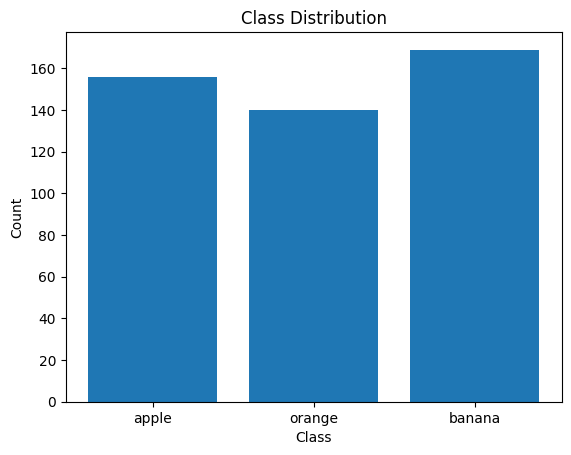

In [4]:
from collections import Counter

train_dir = r"/kaggle/input/fruit-images-for-object-detection/train_zip/train"
labels = []
for fname in os.listdir(train_dir):
    if not fname.endswith(".xml"): continue
    xml_path = os.path.join(train_dir, fname)
    tree = et.parse(xml_path)
    root = tree.getroot()

    for obj in root.findall("object"):
        label = obj.find("name").text
        labels.append(label)

counts = Counter(labels)
plt.bar(counts.keys(), counts.values())
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.show()

### **1.4 Define a Transforms Pipeline for Augmentation**

In [5]:
# transforms.py from vision/references/detection repo
import transforms as T  
 
def get_transforms(train=True):
    transforms = []

    # Conver PIL to torch tensor 
    transforms.append(T.PILToTensor())

    # Normalize image tensor to [0,1]
    transforms.append(T.ToDtype(torch.float32, scale=True))

    if train:
        # Randomly flip images and bboxes
        transforms.append(T.RandomHorizontalFlip(0.5))
    
        # Slightly change color settings
        # transforms.append(T.RandomPhotometricDistort(
        #     brightness=(0.9, 1.1),
        #     contrast=(0.9, 1.1),
        #     saturation=(0.9, 1.1),
        #     hue=(-0.03, 0.03),
        #     p=0.5))
 
    return T.Compose(transforms)

### **1.5 Define a Custom `Dataset` Class**

- Initialize paths, label encoding, and transforms
- `__getitem__` starts by loading an img from the directory
- It parses the image's corresponding XML annotation file
- Convert labels and bboxes into tensors in the required formats
- Compute bbox `area` and assumes `iscrowd` flags are zeroes
- Assemble COCO-style target dict for torch's detection API

In [6]:
class myDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms

        # COCO API implicitly make background class 0
        self.label_enc = {"apple":1, "banana":2, "orange":3}
        self.img_paths = sorted(glob(self.root + '/*.jpg'))
        self.xlm_paths = sorted(glob(self.root + '/*.xml'))
 
    def __getitem__(self, idx):
        # Load and store image
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")  

        # Format and store annotations
        xlm_path = self.xlm_paths[idx]
        xlm = et.parse(xlm_path)
        objects = xlm.findall('object')
        labels = []
        bboxes = []
        for obj in objects:
            label = obj.find('name').text
            labels.append(self.label_enc[label])
            xmin = float(obj.find('bndbox/xmin').text)
            ymin = float(obj.find('bndbox/ymin').text)
            xmax = float(obj.find('bndbox/xmax').text)
            ymax = float(obj.find('bndbox/ymax').text)
            bboxes.append([xmin, ymin, xmax, ymax])

        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)        
        image_id = idx
        area = (bboxes[:,3]-bboxes[:,1]) * (bboxes[:,2]-bboxes[:,0])
        iscrowd = torch.zeros(len(objects), dtype=torch.int64)  

        # Assemble target
        target = {"boxes": bboxes, 
                  "labels": labels,
                  "image_id": image_id, 
                  "area": area,
                  "iscrowd": iscrowd}
 
        if self.transforms:
            img, target = self.transforms(img, target)
 
        return img, target
 
    def __len__(self):
        return len(self.img_paths)

### **1.6 See Dataset Samples**

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


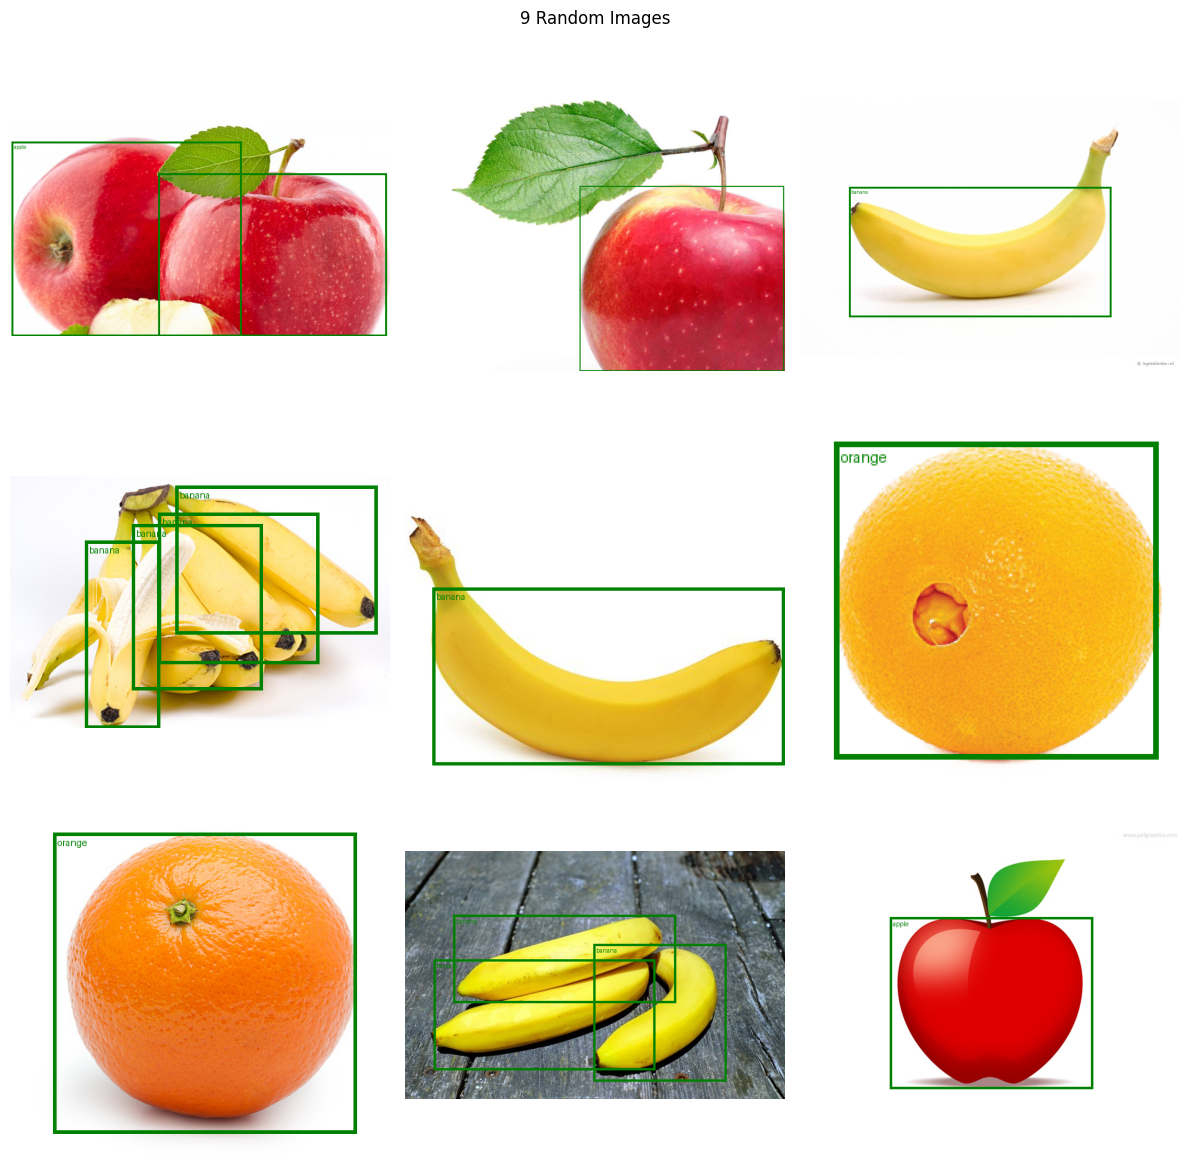

In [7]:
from torchvision.utils import draw_bounding_boxes as dbb
import torchvision.transforms.functional as F

def show_random_images(img_paths, labels_lst, boxes_lst, 
                       n_row=3, n_col=3, use_pred=False,
                       transforms=None):
    """For displaying random images with object boxes and labels."""
    
    fig, axs = plt.subplots(n_row, n_col, figsize=(n_col*4,n_row*4))
    rand_idxs = np.random.choice(len(img_paths), n_row*n_col, replace=False)
    
    for ax, idx in zip(axs.flatten(), rand_idxs):
        img = Image.open(img_paths[idx]).convert("RGB")
        img_tensor = img if transforms else F.to_tensor(img) 
        boxes = boxes_lst[idx]
        labels = labels_lst[idx]
        color = "red" if use_pred else "green"
        
        if len(boxes) > 0:              
            img_uint8 = (img_tensor * 255).to(torch.uint8)
            img_bxs = dbb(img_uint8, boxes, labels, color, width=4)
            img = F.to_pil_image(img_bxs)
        ax.imshow(img)
        ax.axis("off")
    fig.suptitle(f"{n_row*n_col} Random Images")
    plt.tight_layout()
    plt.show()

# Gather image paths
train_dir = r"/kaggle/input/fruit-images-for-object-detection/train_zip/train"
train_paths = sorted(glob(train_dir + '/*.jpg'))

# Getting ground truth labels is much easier from a Dataset object
data = myDataset(train_dir)
label_enc = {1:"apple", 2:"banana", 3:"orange"}
labels_lst = [[label_enc[int(i)] for i in targ["labels"]] for _,targ in data]

# Get ground truth bounding boxes
boxes_lst = [targ["boxes"] for _,targ in data]

# Display the images
show_random_images(train_paths, labels_lst, boxes_lst)

### **1.7 Create `DataLoader` for Training and Validation**

- Create `Dataset` objects for training (80%) and validation (20%) from the original training set
- Wrap both training and validation `Dataset`s with `DataLoader`

In [8]:
import utils

# Training Dataset objects
train_data = myDataset(train_dir, transforms=get_transforms())
val_data   = myDataset(train_dir, transforms=get_transforms(train=False))

idxs = torch.randperm(len(train_data)).tolist()

# Split orig training data for validation (20%)
idxs = torch.randperm(len(train_data)).tolist()
train_data = torch.utils.data.Subset(train_data, idxs[:192])
val_data = torch.utils.data.Subset(val_data, idxs[192:])

# Define training and val DataLoader
train_loader = DataLoader(train_data, 
                          batch_size=4, 
                          shuffle=True, 
                          num_workers=4,
                          collate_fn=utils.collate_fn)

val_loader = DataLoader(val_data, 
                        batch_size=4, 
                        shuffle=False,
                        num_workers=4,
                        collate_fn=utils.collate_fn)

## **2. Model Training**

### **2.1 COCO Metrics Overview**

COCO (Common Objects in Context) metrics are widely used to evaluate object detection models. They measure how well predicted bounding boxes match the ground truth in terms of both location and classification. We evaluate each training epoch using these metrics (as per COCO eval standards).

1. **mAP_all**: Mean Avg Precision across all IoU thresholds (0.5:0.95) and object sizes  
2. **AP50**: AP at IoU = 0.5 (lenient match tolerance)  
3. **AP75**: AP at IoU = 0.75 (stricter match tolerance)  
4. **AP_small**: AP for small objects only  
5. **AP_med**: AP for medium-sized objects  
6. **AP_large**: AP for large objects only 
7. **AR1**: Average Recall for top 1 detection per image  
8. **AR10**: Average Recall for top 10 detections per image  
9. **AR100**: Average Recall for top 100 detections per image  
10. **AR_small**: Average Recall for small objects  
11. **AR_med**: Average Recall for medium objects  
12. **AR_large**: Average Recall for large objects

**Note:** These metrics evaluate both *detection quality* (how accurate the boxes are) and *classification quality*. 

To learn more, see the official evaluation guide: [COCO Detection Evaluation](https://cocodataset.org/#detection-eval)


### **2.2 Define Model and Hyperparameter Settings**

- Define Faster R-CNN model with ResNet50 backbone
- The model has pretrained backbone, RPN, and RoI
- Match the RoI head with the dataset's num of classes
- Define the number of epochs
- Use SGD optimizer with momentum
- Use fixed LR or vary LR per component (backbone, RPN, RoI)
- Apply L2 regularization `weight_decay` during optimization
- Apply `StepLR` or smoother decay via `CosineAnnealingLR`

In [9]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Define Faster R-CNN model
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=4)
model.to(device)

# Set configurations
n_epochs = 15
optimizer = torch.optim.SGD(model.parameters(), lr=5e-3, momentum=0.9, weight_decay=5e-4)
# optimizer = torch.optim.SGD([{"params": model.backbone.parameters(), "lr": 1e-4},
#                              {"params": model.rpn.parameters(),       "lr": 5e-3},
#                              {"params": model.roi_heads.parameters(), "lr": 5e-3}], 
#                             momentum=0.9, weight_decay=5e-4)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 232MB/s] 


### **2.2 Proceed with Model Training**


In [10]:
from engine import train_one_epoch, evaluate
from coco_utils import get_coco_api_from_dataset

# Ignore PIL warnings about palette 
# transparency when converting to RGB
import warnings
warnings.filterwarnings("ignore", message="Palette images with Transparency")

# Store losses from the RPN and RoI head
loss_names = ["loss", "loss_objectness", "loss_rpn_box_reg", 
              "loss_classifier", "loss_box_reg"]
loss_dict = {k:[] for k in loss_names}

# Store COCO-based metrics (AP, AR)
metric_names = ["mAP_all", "AP50", "AP75",
                "AP_small", "AP_med", "AP_large", 
                "AR1", "AR10", "AR100",
                "AR_small", "AR_med", "AR_large"]
metrics_dict = {k:[] for k in metric_names}

# Part of automatic mixed precision
scaler = torch.cuda.amp.GradScaler()

# Training loop 
for epoch in range(1, n_epochs+1):
    loss_metrics = train_one_epoch(model, 
                                   optimizer, 
                                   train_loader, 
                                   device, 
                                   epoch, 
                                   print_freq=12,
                                   scaler=scaler)

    # Collect losses
    for key in loss_dict:
        loss_dict[key].append(loss_metrics.meters[key].avg)

    # Validate
    coco_evaluator = evaluate(model, val_loader, device)
    bbox_metrics = coco_evaluator.coco_eval['bbox'].stats

    # Update LR per set epochs
    # lr_scheduler.step()
    
    # Append metrics
    for key, m in zip(metrics_dict, bbox_metrics):
        metrics_dict[key].append(m)
         
    print("\n","*" * 80,"\n")

/tmp/ipykernel_47/1146525702.py:22: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/kaggle/working/engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [1]  [ 0/48]  eta: 0:02:14  lr: 0.005000  loss: 1.3342 (1.3342)  loss_classifier: 0.9967 (0.9967)  loss_box_reg: 0.3221 (0.3221)  loss_objectness: 0.0017 (0.0017)  loss_rpn_box_reg: 0.0137 (0.0137)  time: 2.8003  data: 0.4178  max mem: 5428
Epoch: [1]  [12/48]  eta: 0:00:32  lr: 0.005000  loss: 0.5781 (0.6898)  loss_classifier: 0.3007 (0.3931)  loss_box_reg: 0.2708 (0.2824)  loss_objectness: 0.0024 (0.0045)  loss_rpn_box_reg: 0.0077 (0.0097)  time: 0.9019  data: 0.0434  max mem: 8427
Epoch: [1]  [24/48]  eta: 0:00:19  lr: 0.005000  loss: 0.4465 (0.5615)  loss_classifier: 0.1698 (0.2796)  loss_box_reg: 0.2630 (0.2670)  loss_objectness: 0.0052 (0.0057)  loss_rpn_box_reg: 0.0077 (0.0093)  time: 0.7190  data: 0.0136  max mem: 8427
Epoch: [1]  [36/48]  eta: 0:00:09  lr: 0.005000  loss: 0.3117 (0.4896)  loss_classifier: 0.1318 (0.2328)  loss_box_reg: 0.1811 (0.2426)  loss_objectness: 0.0034 (0.0048)  loss_rpn_box_reg: 0.0075 (0.0094)  time: 0.6659  data: 0.0126  max mem: 8427
Epoch: [

**Key Takeaways**

- `AP@[0.5:0.95]` is consistently at 0.6, showing decent overall performance across IoU thresholds.
- `AP50` at 0.9 shows good detection quality when only 50% overlap with ground truth is required.
- `AP75` displays an AP drop at a stricter IoU at approximately 0.7.
- The dataset does not contain `small` objects with `0 < area < 1024 px^2`.
- Since there are no small objects, `AP_small` and `AR_small` (flagged `-1.0`) doesn't contribute to the metrics.
- `AR@[maxDets=10]`: Decent recall using only the top 10 detections per image.
- `AR@[maxDets=10]` and `AR@[maxDets=100]` are often identical
- `AR_medium` vs. `AR_large`: Model recalls large objects better than medium ones.
- This could mean "large" objects are the most common in the dataset.

### **2.3 Plot Results**

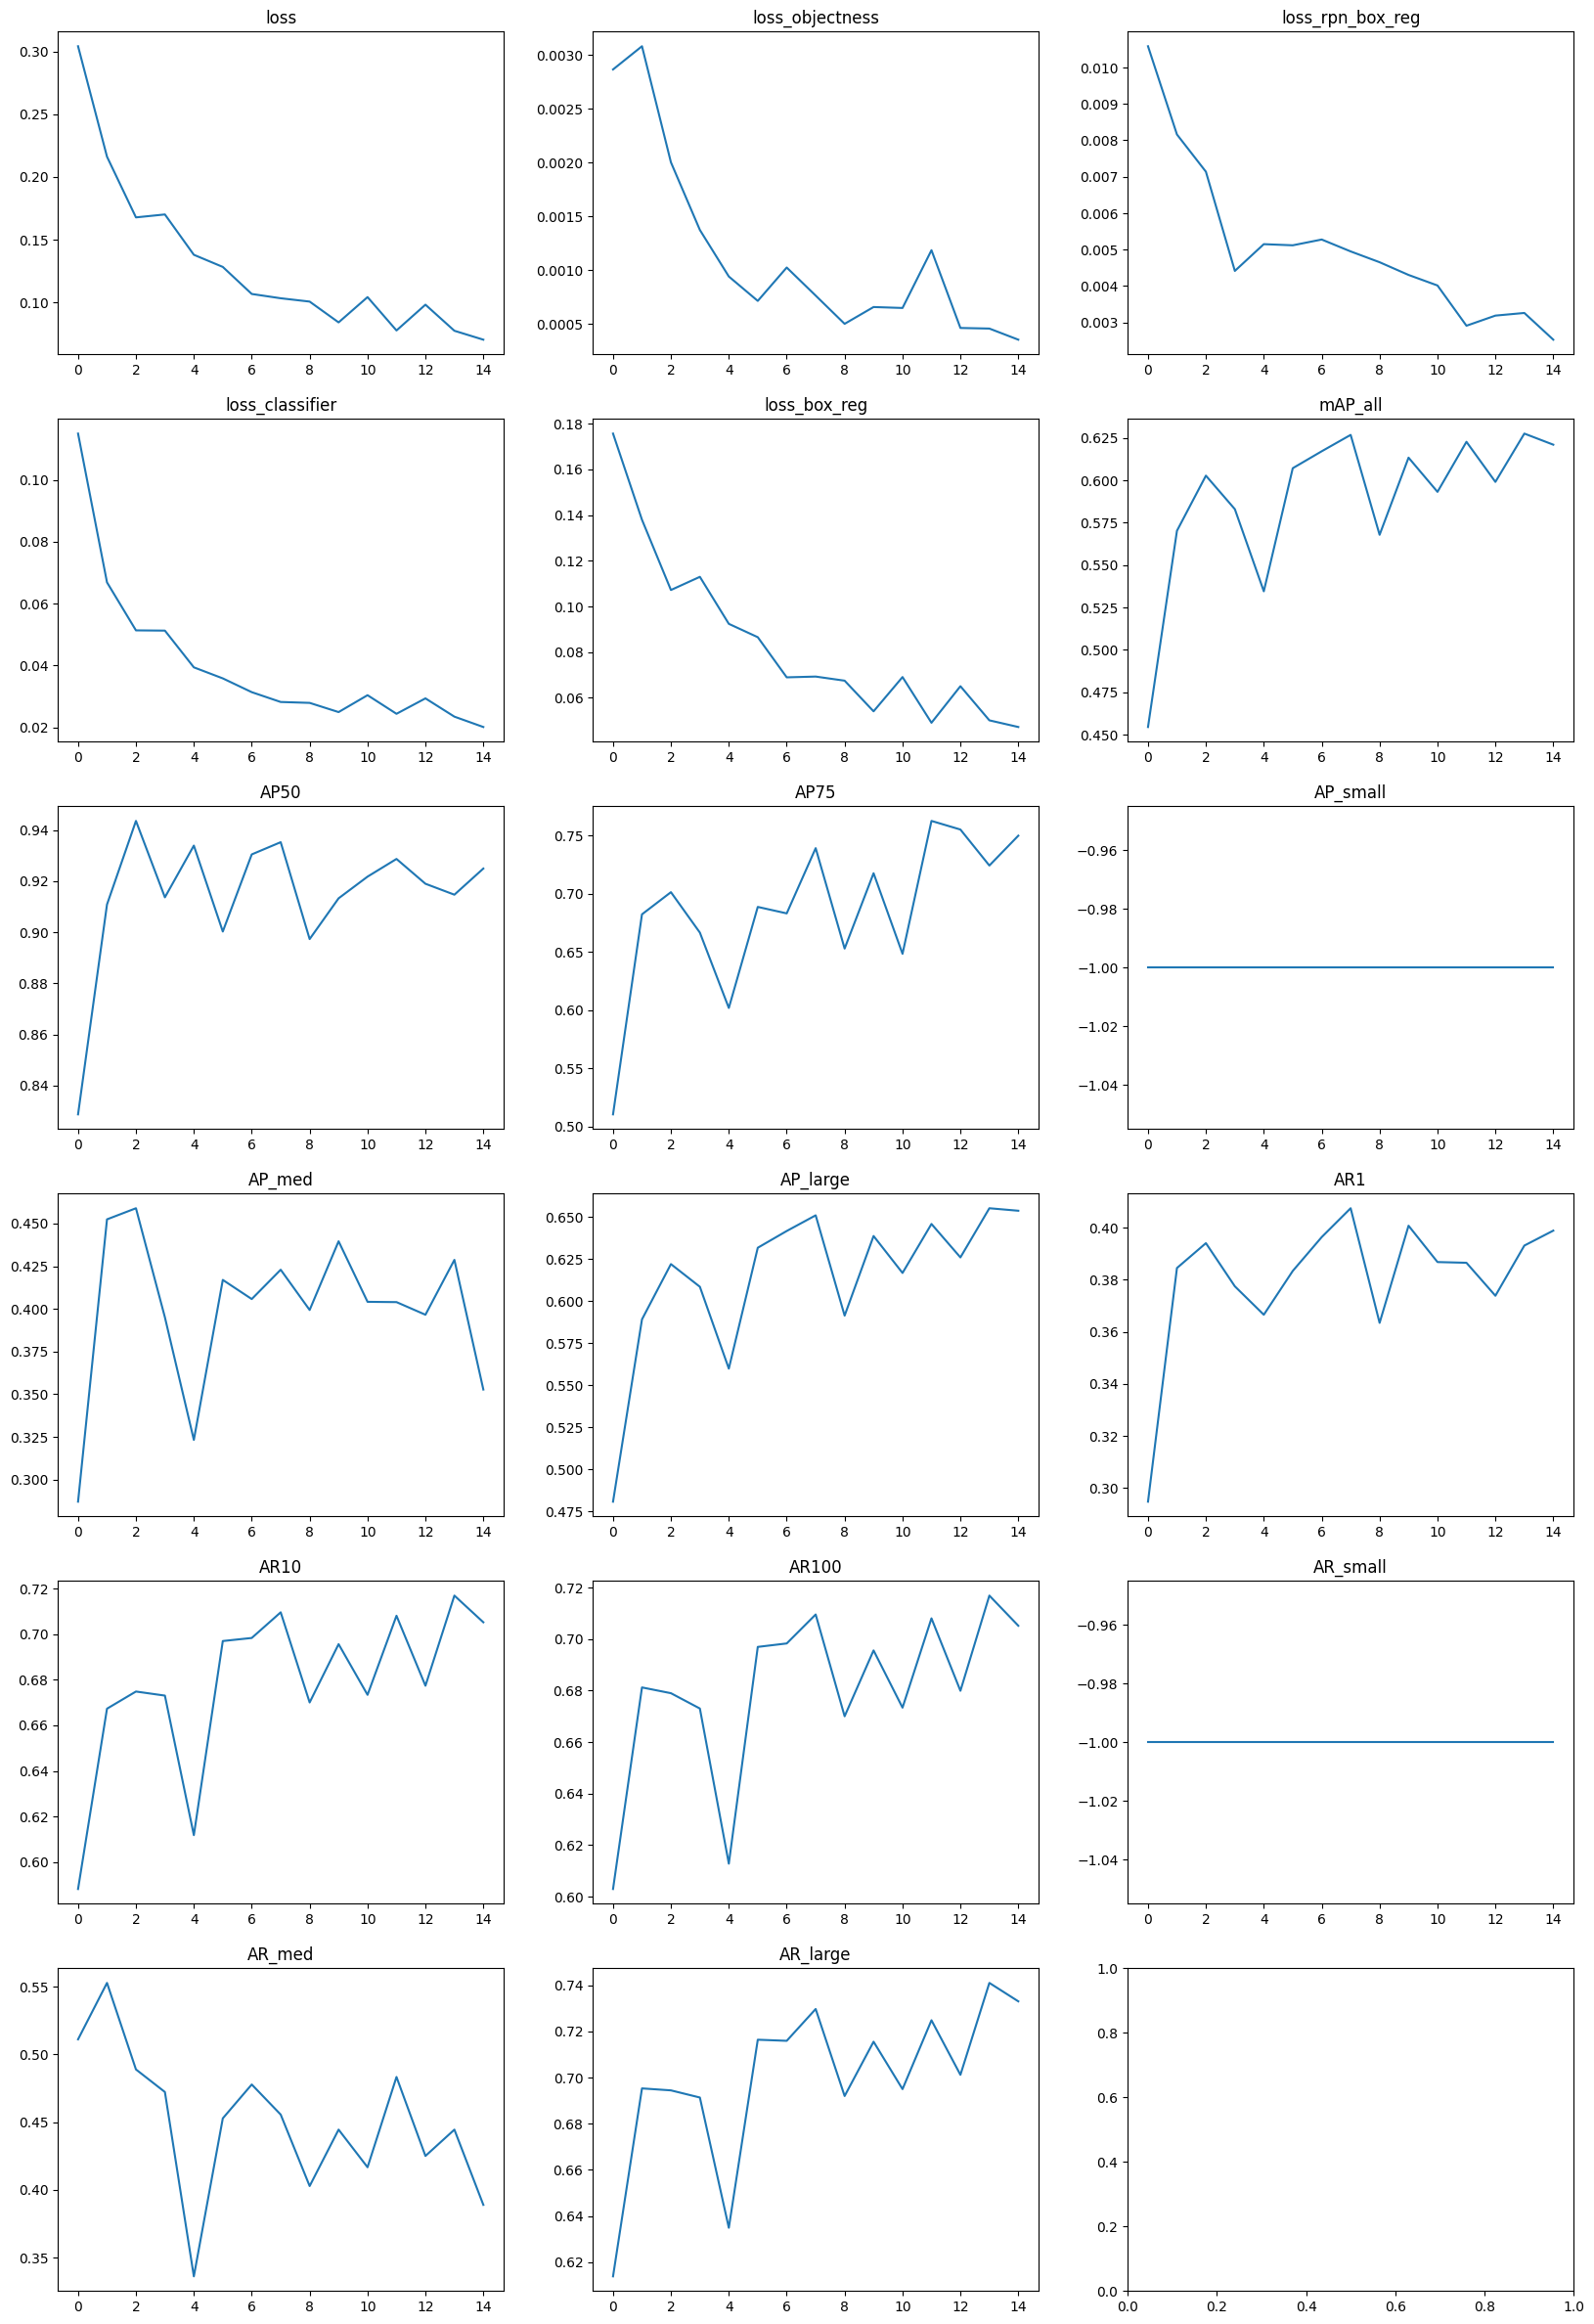

In [11]:
# Plots results over epochs
def plot_metrics(metrics_dict:dict, row:int=6, col:int=3):
    fig, ax = plt.subplots(row, col)
    fig.set_figheight(30)
    fig.set_figwidth(20)
    for stat, (idx, ax) in zip(metrics_dict, enumerate(ax.flatten(), 1)):
        ax.set_title(stat)
        ax.plot(metrics_dict[stat])

# Merge the torch model 
# losses dict and coco metrics dict
stat_dict = loss_dict | metrics_dict
plot_metrics(stat_dict)

## **3. Model Testing** 

### **3.1 Run an Inference on the Test Set** 

In [12]:
# Create test dataset
test_dir = "/kaggle/input/fruit-images-for-object-detection/test_zip/test"
test_data = myDataset(test_dir, get_transforms(train=False))

# Wrap it in DataLoader
test_loader = DataLoader(test_data, 
                        batch_size=4, 
                        shuffle=False,
                        num_workers=4,
                        collate_fn=utils.collate_fn)

# Inference on test dataset
test_evaluator = evaluate(model, test_loader, device)

# Collect results
test_stat = test_evaluator.coco_eval['bbox'].stats 
test_stat_dic = {k:[] for k in metric_names}
for key, m in zip(test_stat_dic, test_stat): test_stat_dic[key].append(m)

creating index...
index created!
Test:  [ 0/15]  eta: 0:00:08  model_time: 0.3053 (0.3053)  evaluator_time: 0.0102 (0.0102)  time: 0.5837  data: 0.2548  max mem: 9147
Test:  [14/15]  eta: 0:00:00  model_time: 0.2608 (0.2722)  evaluator_time: 0.0031 (0.0035)  time: 0.3183  data: 0.0318  max mem: 9147
Test: Total time: 0:00:04 (0.3219 s / it)
Averaged stats: model_time: 0.2608 (0.2722)  evaluator_time: 0.0031 (0.0035)
Accumulating evaluation results...
DONE (t=0.02s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.640
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.954
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.738
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.564
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.654
 Average Recall     (AR) @[ IoU

**Key Takeaways on Final Results:**

- `mAP[0.50:0.95]` is consistent with training performance, suggesting the model generalizes well.
- AP and AR metrics being consistently high across large and medium object sizes (small are absent) and IoU thresholds indicate reliable predictions.
- `AP50` and `AP75` are also in line with training performance. 
- The test data also did not contain `small` objects with `0 < area < 1024 px^2`.
- This means`AP_small` and `AR_small` (flagged `-1.0`) did not contribute to the evaluation metrics.
- `AR10` and `AR100` are again identical and consistent with training performance.

### **3.2 Visualize Predictions** 

Randomly sample a few test images and display all of their predicted bounding boxes and predicted labels.

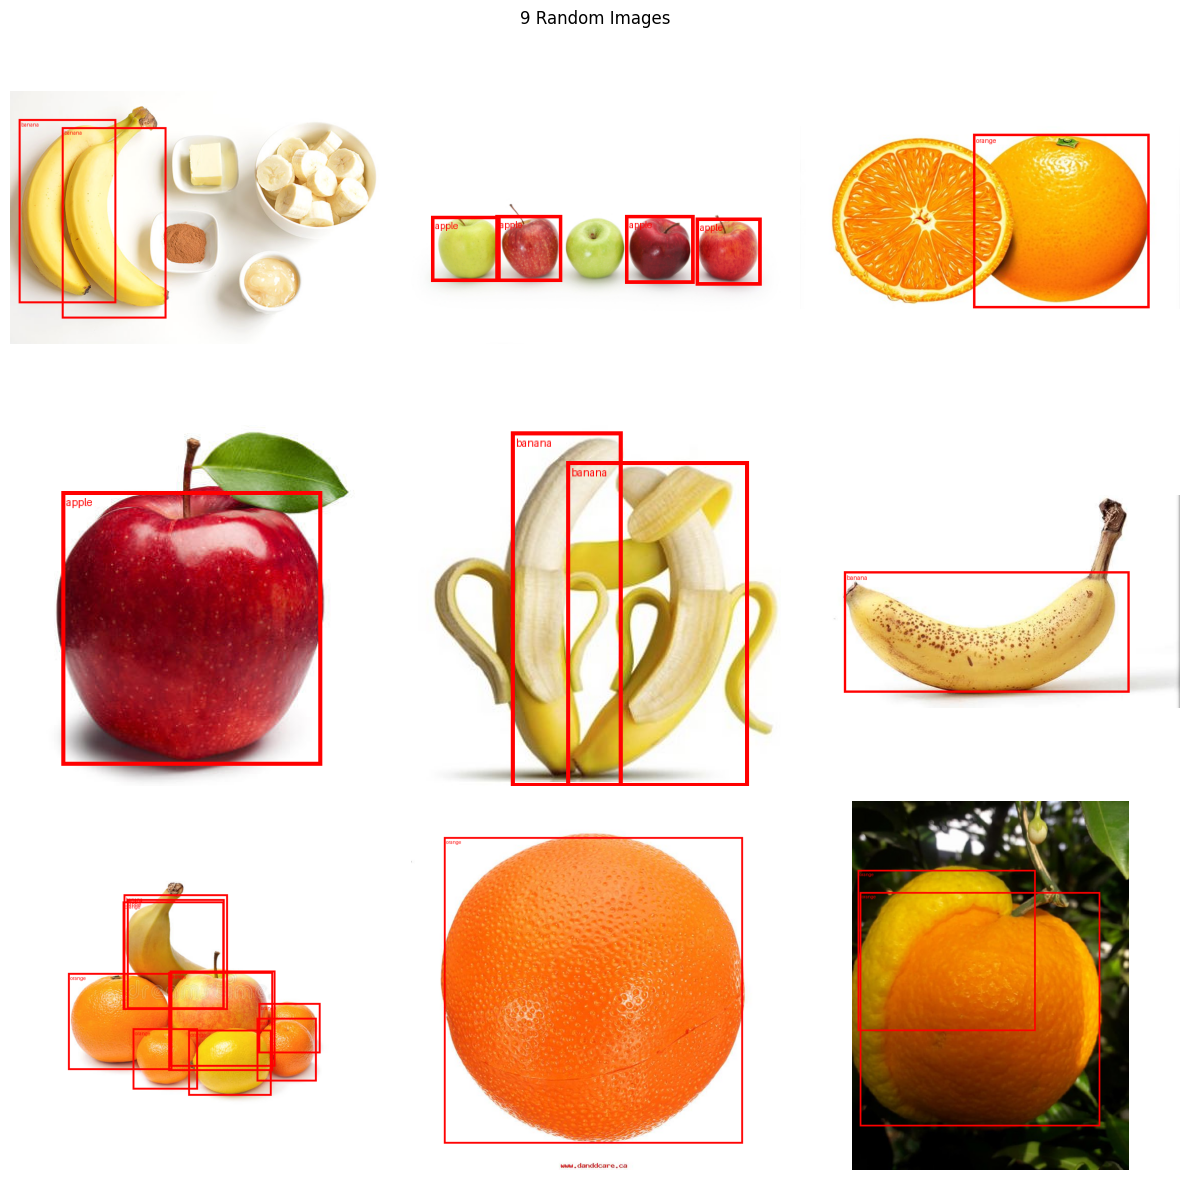

In [13]:
all_preds = []
model.eval()

with torch.no_grad():
    for images, _ in test_loader:
        images = [img.to(device) for img in images]
        outputs = model(images)
        
        for out in outputs:
            all_preds.append({
                "boxes": out["boxes"].cpu(),
                "labels": out["labels"].cpu()})

# Get predicted labels and boxes for display
label_dec = {1:"apple", 2:"banana", 3:"orange"}
pred_labels_lst = [[label_dec[int(c)] for c in pred["labels"]] for pred in all_preds]
pred_boxes_lst  = [pred["boxes"] for pred in all_preds]

# Display the test images with predicted boxes
test_dir = "/kaggle/input/fruit-images-for-object-detection/test_zip/test"
test_paths = sorted(glob(test_dir + '/*.jpg'))
show_random_images(test_paths, pred_labels_lst, pred_boxes_lst, use_pred=True)